## Figure 1 of manuscript showing shapshot of SIC, SSS, and SST for ice bridge

In [1]:
## import required packages
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
from pyproj import Proj, Transformer
import glob
import os
import string
from datetime import datetime

In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:45187")
client

<Client: 'tcp://127.0.0.1:45187' processes=8 threads=32, memory=123.95 GiB>

### Make plot for main manuscript that shows Sept sea ice min, ice bridge, and one week before and after

First calculation sea ice minimum for Beaufort Sea box

In [3]:
# Set data directory and load all matching NetCDF files
data_dir = "/home/jpluser/efs-mount-point/mzahn/satellite_data/sic_nsidc_cdr"
sic_file_paths_2022 = sorted(glob.glob(os.path.join(data_dir, "*2022*.nc")))

data_dir = "/home/jpluser/efs-mount-point/mzahn/satellite_data/sss_rss_smap"
sss_file_paths_2022 = sorted(glob.glob(os.path.join(data_dir, "*2022*.nc")))

data_dir = "/home/jpluser/efs-mount-point/mzahn/satellite_data/sst_noaa_oisst"
sst_file_paths_2022 = sorted(glob.glob(os.path.join(data_dir, "*2022*.nc")))

Plot 2x4 plot

In [4]:
# select specific dates for fig 1
sic_file_paths = [[item for item in sic_file_paths_2022 if '20220922' in item][0],\
                  [item for item in sic_file_paths_2022 if '20221015' in item][0],\
                  [item for item in sic_file_paths_2022 if '20221022' in item][0],\
                  [item for item in sic_file_paths_2022 if '20221029' in item][0]]

In [5]:
# sss is reported in DOY not mon/day
dates = ['20220924', '20221015', '20221022', '20221029']
for date_str in dates:
    dt = datetime.strptime(date_str, '%Y%m%d')
    doy = dt.timetuple().tm_yday
    print(f"{date_str} -> DOY {doy}")

20220924 -> DOY 267
20221015 -> DOY 288
20221022 -> DOY 295
20221029 -> DOY 302


In [6]:
# The SMAP radiometer was put in safehold mode during Julian days 218 – 265 (06 AUG – 21
# SEP) in 2022. No L2C and 8-day L3 files are available during this time period. No monthly L3
# files are produced for AUG – SEP 2022
len(sss_file_paths_2022)

317

In [7]:
# select specific dates for fig 1
sss_file_paths = [[item for item in sss_file_paths_2022 if '2022_267' in item][0],\
                  [item for item in sss_file_paths_2022 if '2022_288' in item][0],\
                  [item for item in sss_file_paths_2022 if '2022_295' in item][0],\
                  [item for item in sss_file_paths_2022 if '2022_302' in item][0]]

In [8]:
tmp = xr.open_dataset(sss_file_paths[2])

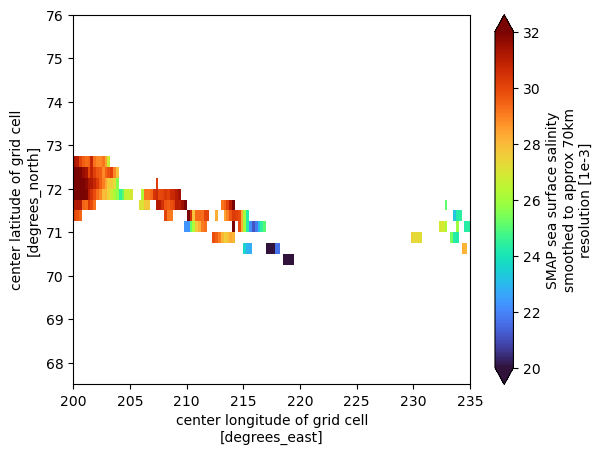

In [9]:
tmp.sss_smap.plot(vmin=20,vmax=32,cmap='turbo');
plt.xlim(200,235)
plt.ylim(67.5,76);

In [10]:
# select specific dates for fig 1
sst_file_paths = [[item for item in sst_file_paths_2022 if '20220924' in item][0],\
                  [item for item in sst_file_paths_2022 if '20221015' in item][0],\
                  [item for item in sst_file_paths_2022 if '20221022' in item][0],\
                  [item for item in sst_file_paths_2022 if '20221029' in item][0]]

In [11]:
tmp = xr.open_dataset(sst_file_paths[0])

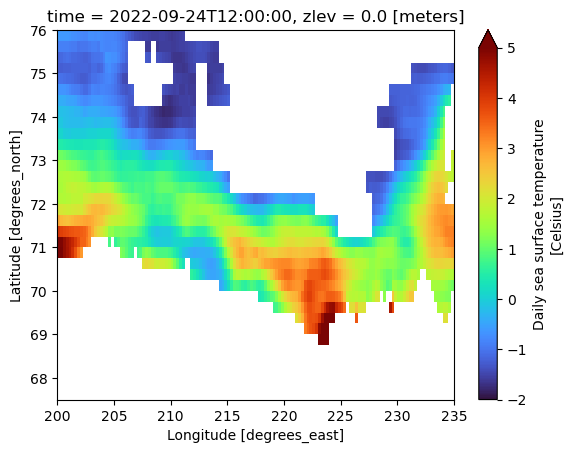

In [12]:
tmp.sst.where(tmp.ice.isnull()).plot(vmin=-2,vmax=5,cmap='turbo');
plt.xlim(200,235)
plt.ylim(67.5,76);

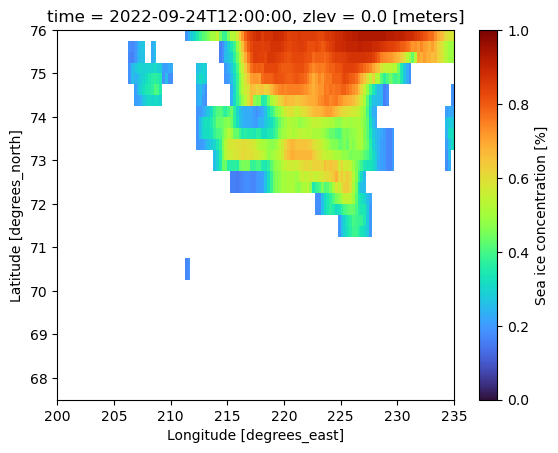

In [13]:
tmp.ice.plot(vmin=0,vmax=1,cmap='turbo');
plt.xlim(200,235)
plt.ylim(67.5,76);

In [14]:
def remap_colormap(cmap, nonlin_scale=np.sqrt, n=256):
    """
    Remap a colormap so that lower values are compressed (darker colors take up less space),
    and higher values (lighter colors) are stretched out.
    
    Parameters:
    - cmap: The original colormap (e.g., cmocean.cm.ice)
    - nonlin_scale: A function that maps [0,1] -> [0,1] nonlinearly (default: np.sqrt)
    - n: Number of color levels
    
    Returns:
    - A new colormap with redistributed colors.
    """
    # Generate linearly spaced values, then apply non-linear scaling
    orig_vals = np.linspace(0, 1, n)
    remapped_vals = nonlin_scale(orig_vals)

    # Normalize remapped values to stay in [0,1]
    remapped_vals = (remapped_vals - remapped_vals.min()) / (remapped_vals.max() - remapped_vals.min())

    # Map those values through the original colormap
    new_colors = cmap(remapped_vals)
    
    return LinearSegmentedColormap.from_list(f'remapped_{cmap.name}', new_colors, N=n)

In [15]:
from matplotlib.colors import LinearSegmentedColormap

# create a nonlinearly adjusted colormap from the cmocean ice colormap
custom_ice_cmap = remap_colormap(cmocean.cm.ice, nonlin_scale=np.sqrt)  # sqrt compresses low end

In [17]:
# open geometry file for HH field
HH_grid = xr.open_dataset("~/efs-mount-point/mzahn/sassie/HH/GRID/GRID_GEOMETRY_SASSIE_HH_V1R1_NATIVE_LLC1080.nc")

# get lat/lon coordinates of model box
grid_beaufort = HH_grid.isel(i=slice(510,750),j=slice(110,390))

In [18]:
print(grid_beaufort.Z.values[0:17])
print(grid_beaufort.drF.values[0:17])

[ -0.5    -1.57   -2.79   -4.185  -5.78   -7.595  -9.66  -12.01  -14.68
 -17.705 -21.125 -24.99  -29.345 -34.24  -39.725 -45.855 -52.69 ]
[1.   1.14 1.3  1.49 1.7  1.93 2.2  2.5  2.84 3.21 3.63 4.1  4.61 5.18
 5.79 6.47 7.2 ]


In [19]:
def get_full_edge_boundary(lat_da, lon_da):
    """Extract full edge of 2D lat/lon DataArrays as a continuous boundary (closed polygon)."""

    ny, nx = lat_da.shape

    def flatten_edge(da):
        # Remove coord info, rename dimension to 'points'
        return da.reset_coords(drop=True).rename({da.dims[0]: 'points'})

    # Top edge (left to right)
    top_lat = flatten_edge(lat_da.isel(j=0))
    top_lon = flatten_edge(lon_da.isel(j=0))

    # Right edge (top to bottom, skip first point to avoid duplication)
    right_lat = flatten_edge(lat_da.isel(i=nx-1).isel(j=slice(1, ny)))
    right_lon = flatten_edge(lon_da.isel(i=nx-1).isel(j=slice(1, ny)))

    # Bottom edge (right to left, skip first point)
    bottom_lat = flatten_edge(lat_da.isel(j=ny-1).isel(i=slice(0, nx-1))[::-1])
    bottom_lon = flatten_edge(lon_da.isel(j=ny-1).isel(i=slice(0, nx-1))[::-1])

    # Left edge (bottom to top, skip first point)
    left_lat = flatten_edge(lat_da.isel(i=0).isel(j=slice(0, ny-1))[::-1])
    left_lon = flatten_edge(lon_da.isel(i=0).isel(j=slice(0, ny-1))[::-1])

    # Concatenate all edges into a closed loop
    lat_boundary = xr.concat([top_lat, right_lat, bottom_lat, left_lat], dim='points')
    lon_boundary = xr.concat([top_lon, right_lon, bottom_lon, left_lon], dim='points')

    return lat_boundary, lon_boundary
    # return top_lat, top_lon

In [20]:
lat_boundary, lon_boundary = get_full_edge_boundary(grid_beaufort['YC'], grid_beaufort['XC'])

### Globe version

In [21]:
bathy_ds = xr.open_dataset('/home/jpluser/efs-mount-point/mzahn/bathy/gebco_2024_n90.0_s50.0_w-180.0_e180.0.nc')
bathy_south_ds = xr.open_dataset('/home/jpluser/efs-mount-point/mzahn/bathy/gebco_2024_n50.0_s20.0_w-180.0_e180.0.nc')

In [22]:
bathy = bathy_ds.elevation*-1 # make increasing positive with depth
bathy_south = bathy_south_ds.elevation*-1

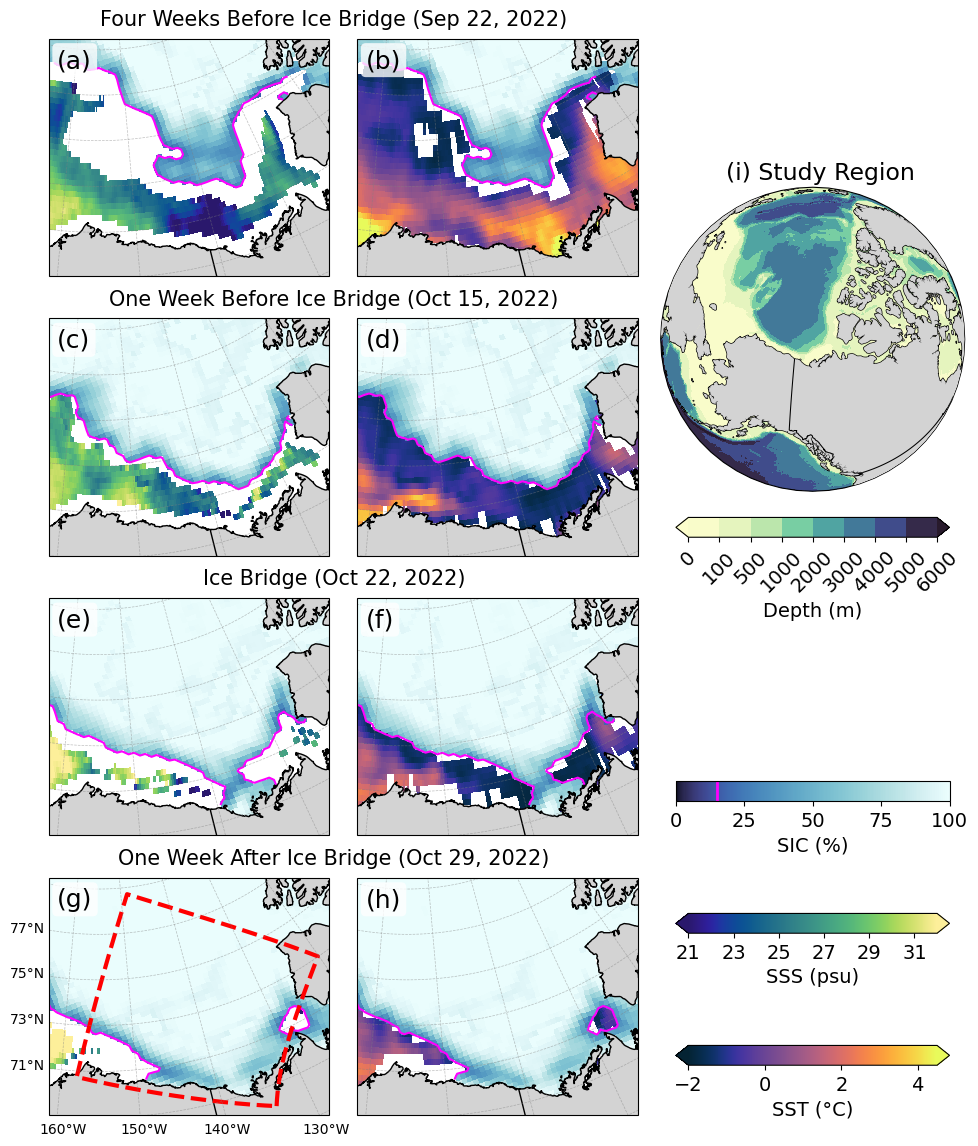

In [23]:
# Set font size
plt.rcParams['font.size'] = 14

# Define NSIDC stereographic projection
nsidc_proj = Proj(proj='stere', lat_0=90, lon_0=-45, lat_ts=70,
                  a=6378273, b=6356889.449, units='m')
transformer = Transformer.from_proj(nsidc_proj, "epsg:4326", always_xy=True)

# Create 4x2 plot
fig, axes = plt.subplots(4, 2, figsize=(7.6, 13.2),
                         subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=-155)})
plt.subplots_adjust(wspace=0.1, hspace=0.15, right=0.9, top=0.93)
axes = axes.reshape(4, 2)

labels = list(string.ascii_lowercase)
pcolormesh_handle = None
sss_im_list = []
sst_im_list = []

for i in range(len(sic_file_paths)):
    sic_ds = xr.open_dataset(sic_file_paths[i])
    sic = sic_ds['cdr_seaice_conc'].squeeze()
    if sic.max() > 1.5:
        sic = sic / 100.0
    sic_masked = np.where(sic > 0.15, sic, np.nan)

    sss = xr.open_dataset(sss_file_paths[i])['sss_smap'].squeeze()
    sst = xr.open_dataset(sst_file_paths[i])['sst'].squeeze()
    sst_ice = xr.open_dataset(sst_file_paths[i])['ice'].squeeze()

    x = sic_ds['x'].values
    y = sic_ds['y'].values
    X, Y = np.meshgrid(x, y)
    lon, lat = transformer.transform(X, Y)

    row_titles = ["Four Weeks Before Ice Bridge", "One Week Before Ice Bridge", "Ice Bridge", "One Week After Ice Bridge"]
    dt = pd.to_datetime(sic_ds['time'].values)
    date_str = dt.strftime('%b %d, %Y')
    row_title = f"{row_titles[i]} ({date_str[0]})"
    row_top_y = max(axes[i, 0].get_position().y1, axes[i, 1].get_position().y1)
    fig.text(0.5, row_top_y + 0.008, row_title, ha='center', fontsize=15)

    for j in range(2):
        ax = axes[i, j]
        ax.set_extent([-161, -126, 69, 78], crs=ccrs.PlateCarree())
        ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', facecolor='lightgray'))
        ax.add_feature(cfeature.BORDERS.with_scale('10m'))
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'))
        gl = ax.gridlines(draw_labels=False, linewidth=0.5, color='gray',
                          alpha=0.5, linestyle='--', ylocs=[67, 69, 71, 73, 75, 77, 79])

        if j == 0:
            sss_cb = sss.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmocean.cm.haline,
                              vmin=21, vmax=32, add_colorbar=False, extend='both')
        else:
            sst_cb = sst.where(sst_ice.isnull()).plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmocean.cm.thermal,
                              vmin=-2, vmax=4.5, add_colorbar=False, extend='both')

        sic_cb = ax.pcolormesh(lon, lat, sic_masked * 100, transform=ccrs.PlateCarree(),
                               cmap=custom_ice_cmap, shading='auto', vmin=0, vmax=100)

        ax.set_title("")

        regional_mask = ((lon >= -165) & (lon <= -120) & (lat >= 66) & (lat <= 80))
        sic_region = np.where(regional_mask, sic, np.nan)
        ax.contour(lon, lat, sic_region * 100, levels=[15], colors='magenta',
                   linewidths=1.5, transform=ccrs.PlateCarree())

        ax.text(0.03, 0.96, f'({labels[i * 2 + j]})', transform=ax.transAxes,
                fontsize=18, va='top', ha='left',
                bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2', alpha=0.8))

# Colorbars
cbar_ax_sss = fig.add_axes([0.95, 0.25, 0.36, 0.015])
cb_sss = fig.colorbar(sss_cb, cax=cbar_ax_sss, orientation='horizontal', extend='both')
cb_sss.set_label('SSS (psu)')
cb_sss.set_ticks([21,23,25,27,29,31])

cbar_ax_sic = fig.add_axes([0.95, 0.35, 0.36, 0.015])
cb_sic = fig.colorbar(sic_cb, cax=cbar_ax_sic, orientation='horizontal')
cb_sic.set_label('SIC (%)')
cb_sic.ax.vlines(15, *cb_sic.ax.get_xlim(), colors='magenta', linewidth=2)

cbar_ax_sst = fig.add_axes([0.95, 0.15, 0.36, 0.015])
cb_sst = fig.colorbar(sst_cb, cax=cbar_ax_sst, orientation='horizontal', extend='both')
cb_sst.set_label('SST (°C)')

# Lat/lon labels
fig.text(0.12, 0.15, '71°N', fontsize=10, ha='right', va='center')
fig.text(0.12, 0.185, '73°N', fontsize=10, ha='right', va='center')
fig.text(0.12, 0.22, '75°N', fontsize=10, ha='right', va='center')
fig.text(0.12, 0.254, '77°N', fontsize=10, ha='right', va='center')
fig.text(0.144, 0.107, '160°W', fontsize=10, ha='center', va='top')
fig.text(0.25, 0.107, '150°W', fontsize=10, ha='center', va='top')
fig.text(0.36, 0.107, '140°W', fontsize=10, ha='center', va='top')
fig.text(0.49, 0.107, '130°W', fontsize=10, ha='center', va='top')

# Plot model domain
ax = axes[-1, 0]
ax.plot(lon_boundary, lat_boundary, 'r', transform=ccrs.PlateCarree(),
        linewidth=3, linestyle='dashed', label='Model Domain')

# Define Nearside Perspective projection
# Center it over Mackenzie River region
proj = ccrs.NearsidePerspective(central_longitude=-135, central_latitude=72, satellite_height=1285831)
inset_ax = fig.add_axes([0.93, 0.5, 0.4, 0.4], projection=proj)

# Plot bathymetry (subsampled)
bathy_select = bathy.isel(lat=slice(None,None,30), lon=slice(None,None,30))
bathy_select_south = bathy_south.isel(lat=slice(None,None,30), lon=slice(None,None,30))

bathy_levels = [0, 100, 500, 1000, 2000, 3000, 4000, 5000, 6000]
bathy_cb = inset_ax.contourf(
    bathy_select.lon, bathy_select.lat, bathy_select,
    levels=bathy_levels, extend='both',
    cmap=cmocean.cm.deep,
    transform=ccrs.PlateCarree()
)
inset_ax.contourf(
    bathy_select_south.lon, bathy_select_south.lat, bathy_select_south,
    levels=bathy_levels,
    cmap=cmocean.cm.deep,
    transform=ccrs.PlateCarree()
)

# Add coastlines and land
inset_ax.coastlines(resolution='50m', linewidth=1)
inset_ax.add_feature(cfeature.BORDERS, linewidth=0.75,zorder=6)
inset_ax.add_feature(cfeature.LAND, facecolor='lightgray',zorder=5)

# Add title and label
inset_ax.set_title("  (i) Study Region", fontsize=17)

# add colorbar for bathy
cbar_ax_bathy = fig.add_axes([0.95, 0.55, 0.36, 0.015])
cb_bathy = fig.colorbar(bathy_cb, cax=cbar_ax_bathy, boundaries=bathy_levels, ticks=bathy_levels, orientation='horizontal', extend='both')
cb_bathy.set_label('Depth (m)')
cb_bathy.ax.tick_params(labelrotation=45)

# Show or save
# fig.savefig('/home/jpluser/git_repos/SASSIE_ECCO_salinity_stratification/figures/fig1.png', dpi=300, bbox_inches='tight')
plt.show()